# Imports

In [ ]:
%pip install --upgrade z3-solver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 21.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine

In [ ]:
from z3 import *
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree as sk_tree
from matplotlib import pyplot as plt

In [ ]:
set_option(rational_to_decimal=True)

# Functions

In [ ]:
def multiclass_initial_prediction(y, n_classes):
    class_counts = np.bincount(y, minlength=n_classes)
    class_probs = class_counts / len(y)

    log_odds = np.log(class_probs + 1e-15)
    return log_odds - log_odds.mean()

In [ ]:
def binary_initial_prediction(y):
    pi = np.mean(y)

    initial_log_odds = np.log(pi / (1 - pi))

    return initial_log_odds

In [ ]:
def compare_decision_function(model, X, initial_prediction=None):
    learning_rate = model.learning_rate
    estimators = model.estimators_
    estimator_results = []

    if initial_prediction is None and model.init_ != 'zero':
        print("Error - Missing initial_prediction")
        return None

    for estimator in estimators:
        class_predictions = [tree.predict(X) for tree in estimator]
        estimator_results.append(np.array(class_predictions).T)

    final_predictions = np.sum(estimator_results, axis=0) * learning_rate

    if model.init_ != 'zero':
            final_predictions += initial_prediction

    if np.isscalar(initial_prediction) and initial_prediction != None:
      final_predictions = final_predictions.flatten()

    if not np.allclose(final_predictions, model.decision_function(X)):
      print("Error - Deicison Function does not match")

    return final_predictions

In [ ]:
def print_init_decision_function(model, X):
  X = [X[1]]

  decision = model.decision_function(X)
  print(decision)

  learning_rate = model.learning_rate
  estimators = model.estimators_
  estimator_results = []
  for estimator in estimators:
        class_predictions = [tree.predict(X) for tree in estimator]
        estimator_results.append(np.array(class_predictions).T)

  final_predictions = np.sum(estimator_results, axis=0) * learning_rate
  print(final_predictions)

  return decision - final_predictions

# Test Function

## Multiclass

In [ ]:
gb_multiclass = GradientBoostingClassifier(n_estimators = 2)

In [ ]:
iris = load_iris()
X_iris, y_iris = iris.data, iris.target
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris, y_iris, test_size=0.1, random_state=101)

In [ ]:
gb_multiclass.fit(X_iris_train, y_iris_train)

GradientBoostingClassifier(n_estimators=2)

In [ ]:
gb_multiclass.init_

DummyClassifier()

In [ ]:
gb_multiclass.decision_function(X_iris_test)

array([[ 0.35084085, -0.15511048, -0.21511215],
       [ 0.35084085, -0.15511048, -0.21511215],
       [ 0.35084085, -0.15511048, -0.21511215],
       [-0.21526034,  0.07323811, -0.21789365],
       [-0.21501958,  0.38382644, -0.21511549],
       [-0.21526034, -0.15511048,  0.3564349 ],
       [-0.21501958,  0.38382644, -0.21511549],
       [-0.21501958,  0.38382644, -0.21511549],
       [-0.21526034, -0.15511048,  0.3564349 ],
       [ 0.35084085, -0.15511048, -0.21511215],
       [-0.21526034, -0.15511048,  0.35084085],
       [ 0.35084085, -0.15511048, -0.21511215],
       [ 0.35084085, -0.15511048, -0.21511215],
       [-0.21526034, -0.15511048,  0.35084085],
       [-0.21526034, -0.15511048,  0.18139282]])

In [ ]:
mydecision = compare_decision_function(gb_multiclass, X_iris_test)
mydecision

Error - Missing initial_prediction


In [ ]:
multiclass_init = multiclass_initial_prediction(y_iris_train, 3)
multiclass_init

array([-0.02198599,  0.04397198, -0.02198599])

In [ ]:
print_init_decision_function(gb_multiclass, X_iris_test)

[[ 0.35084085 -0.15511048 -0.21511215]]
[[ 0.37282684 -0.19908246 -0.19312616]]


array([[-0.02198599,  0.04397198, -0.02198599]])

In [ ]:
initprediction = compare_decision_function(gb_multiclass, X_iris_test, multiclass_init)
initprediction

array([[ 0.35084085, -0.15511048, -0.21511215],
       [ 0.35084085, -0.15511048, -0.21511215],
       [ 0.35084085, -0.15511048, -0.21511215],
       [-0.21526034,  0.07323811, -0.21789365],
       [-0.21501958,  0.38382644, -0.21511549],
       [-0.21526034, -0.15511048,  0.3564349 ],
       [-0.21501958,  0.38382644, -0.21511549],
       [-0.21501958,  0.38382644, -0.21511549],
       [-0.21526034, -0.15511048,  0.3564349 ],
       [ 0.35084085, -0.15511048, -0.21511215],
       [-0.21526034, -0.15511048,  0.35084085],
       [ 0.35084085, -0.15511048, -0.21511215],
       [ 0.35084085, -0.15511048, -0.21511215],
       [-0.21526034, -0.15511048,  0.35084085],
       [-0.21526034, -0.15511048,  0.18139282]])

## Binary

In [ ]:
gb_binary = GradientBoostingClassifier(n_estimators = 10)

In [ ]:
cancer = load_breast_cancer()
X_cancer, y_cancer = cancer.data, cancer.target
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, y_cancer, test_size=0.01, random_state=101)

In [ ]:
gb_binary.fit(X_cancer_train, y_cancer_train)

GradientBoostingClassifier(n_estimators=10)

In [ ]:
gb_binary.init_

DummyClassifier()

In [ ]:
gb_binary.decision_function(X_cancer_test)

array([ 1.7894355 ,  1.7894355 ,  1.7894355 , -1.25587636,  1.7894355 ,
        1.7894355 ])

In [ ]:
binary_init = binary_initial_prediction(y_cancer_train)
binary_init

0.5117730421220308

In [ ]:
print_init_decision_function(gb_binary, X_cancer_test)

[1.7894355]
[[1.27766246]]


array([[0.51177304]])

In [ ]:
initprediction = compare_decision_function(gb_binary, X_cancer_test, binary_init)
initprediction

array([ 1.7894355 ,  1.7894355 ,  1.7894355 , -1.25587636,  1.7894355 ,
        1.7894355 ])

# z3 decision function

In [ ]:
binpred = gb_binary.predict([X_cancer_test[0]])
binpred

array([1])

In [ ]:
gb_binary.estimators_[0][0]

DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      random_state=RandomState(MT19937) at 0x7FED9D7B5E40)

In [ ]:
gb_multiclass.decision_function(X_iris_test)

array([[ 0.35084085, -0.15511048, -0.21511215],
       [ 0.35084085, -0.15511048, -0.21511215],
       [ 0.35084085, -0.15511048, -0.21511215],
       [-0.21526034,  0.07323811, -0.21789365],
       [-0.21501958,  0.38382644, -0.21511549],
       [-0.21526034, -0.15511048,  0.3564349 ],
       [-0.21501958,  0.38382644, -0.21511549],
       [-0.21501958,  0.38382644, -0.21511549],
       [-0.21526034, -0.15511048,  0.3564349 ],
       [ 0.35084085, -0.15511048, -0.21511215],
       [-0.21526034, -0.15511048,  0.35084085],
       [ 0.35084085, -0.15511048, -0.21511215],
       [ 0.35084085, -0.15511048, -0.21511215],
       [-0.21526034, -0.15511048,  0.35084085],
       [-0.21526034, -0.15511048,  0.18139282]])

In [ ]:
y_cancer_test

array([1, 1, 1, 0, 1, 1])

In [ ]:
gb_binary.predict(X_cancer_test[2:4])

array([1, 0])

In [ ]:
gb_binary.decision_function(X_cancer_test[2:4])

array([ 1.7894355 , -1.25587636])

In [ ]:
binpred = gb_binary.predict([X_cancer_test[5]])
binpred, gb_binary.decision_function([X_cancer_test[5]])

(array([1]), array([1.7894355]))

In [ ]:
gb_binary.n_estimators

10

A = (O_0_0 + O_1_0) * alpha * init_ > 0

In [ ]:
# prompt: get number of classes in gb_binary

gb_binary.n_classes_

2

In [ ]:
listaux = []
for i in range(10):
  if gb_binary.n_classes_ <= 2:
    o = Real(f'o_{i}_0')
    listaux.append(o)
    print(o)

o_0_0
o_1_0
o_2_0
o_3_0
o_4_0
o_5_0
o_6_0
o_7_0
o_8_0
o_9_0


In [ ]:
sum_listaux = Sum(listaux)
sum_listaux

o_0_0 +
o_1_0 +
o_2_0 +
o_3_0 +
o_4_0 +
o_5_0 +
o_6_0 +
o_7_0 +
o_8_0 +
o_9_0

In [ ]:
binary_init

0.5117730421220308

In [ ]:
mult_listaux = (sum_listaux * gb_binary.learning_rate + binary_init) > 0
mult_listaux

(o_0_0 +
 o_1_0 +
 o_2_0 +
 o_3_0 +
 o_4_0 +
 o_5_0 +
 o_6_0 +
 o_7_0 +
 o_8_0 +
 o_9_0)*
1/10 +
1279432605305077/2500000000000000 >
0

In [ ]:
listaux

[o_0_0, o_1_0, o_2_0, o_3_0, o_4_0, o_5_0, o_6_0, o_7_0, o_8_0, o_9_0]

In [ ]:
equation = o * gb_binary.learning_rate
equation

o_9_0*1/10

In [ ]:
def function_a(model, x):
  learning_rate = model.learning_rate
  decision = model.decision_function(x)
  n_classes = 1 if model.n_classes_ <= 2 else model.n_classes_
  predicted_class = model.predict(x)[0]

  print('pred class:', predicted_class)

  estimators = model.estimators_
  estimator_results = []
  for estimator in estimators:
    class_predictions = [tree.predict(x) for tree in estimator]
    estimator_results.append(class_predictions)

  estimator_sum = np.sum(estimator_results, axis=0) * learning_rate
  init_value = decision - estimator_sum

  equation_list = []
  for class_number in range(n_classes):
    estimator_list = []
    for estimator_number in range(len(estimators)):
      # print(f"o_{estimator_number}_{class_number}")
      o = Real(f'o_{estimator_number}_{class_number}')
      estimator_list.append(o)
    equation_o = Sum(estimator_list) * learning_rate + init_value[0][class_number]
    equation_list.append(equation_o)

  if n_classes <= 2:
    if predicted_class == 0:
      final_equation = equation_list[0] < 0
    else:
      final_equation = equation_list[0] > 0
  else:
    compare_equation = []
    for class_number in range(n_classes):
      if predicted_class != class_number:
        compare_equation.append(equation_list[predicted_class] > equation_list[class_number])
    final_equation = compare_equation

  return And(final_equation)

In [ ]:
o = Real(f'o_{1}')
val = RealVal(1.856)
equal = (o == val)
equal

232/125 == o_1

o_0_0 == 1,235
o_0_1 == 1,2354

x0 == 5
x1 == 3
x2 == 2

In [ ]:
binz3 = function_a(gb_binary, [X_cancer_test[0]])
print(binz3)

pred class: 1
And((o_0_0 +
     o_1_0 +
     o_2_0 +
     o_3_0 +
     o_4_0 +
     o_5_0 +
     o_6_0 +
     o_7_0 +
     o_8_0 +
     o_9_0)*
    0.1 +
    0.5117730421? <
    0)


In [ ]:
multz3 = function_a(gb_multiclass, [X_iris_test[0]])
print(multz3)

pred class: 0
And((o_0_0 + o_1_0)*0.1 + -0.0219859892? >
    (o_0_1 + o_1_1)*0.1 + -0.5279373234?,
    (o_0_0 + o_1_0)*0.1 + -0.0219859892? >
    (o_0_2 + o_1_2)*0.1 + -0.5879389930?)


o_0_0 == 1,235
o_0_1 == 1,2354

In [ ]:
s = Solver()
A = Bool('A')
F = Bool('F')
s.add(Implies(A, F))
s.check()

sat

# z3 Regression trees

In [ ]:
gb_multiclass.estimators_.shape

(2, 3)

In [ ]:
tree = gb_multiclass.estimators_[1][2]
tree

DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      random_state=RandomState(MT19937) at 0x7FED9D7B5E40)

In [ ]:
# Função para coletar uma fórmula AND com todas as implicações dos caminhos da árvore
def get_all_paths_with_z3(tree, tree_index, class_index):
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    value = tree_.value

    paths = []
    o = Real(f'o_{tree_index}_{class_index}')  # Variável de saída específica para árvore e classe

    # Função recursiva para percorrer a árvore e acumular fórmulas z3
    def traverse(node, path_conditions):
        # Se o nó é uma folha
        if feature[node] == -2:
            leaf_value = value[node][0][0]
            # Cria uma fórmula que combina todas as condições do caminho para esta folha
            path_formula = And(path_conditions)
            # Cria a implicação: se path_formula então y == leaf_value
            implication = Implies(path_formula, o == leaf_value)
            paths.append(implication)
        else:
            # Criação das variáveis z3 correspondentes às features
            x = Real(f'x{feature[node]}')
            left_condition = x <= threshold[node]
            right_condition = x > threshold[node]

            # Ramo esquerdo (condição True no nó)
            traverse(tree_.children_left[node], path_conditions + [left_condition])
            # Ramo direito (condição False no nó)
            traverse(tree_.children_right[node], path_conditions + [right_condition])

    # Iniciando a travessia da árvore
    traverse(0, [])

    # Combina todas as implicações em uma única fórmula AND
    return And(*paths)

In [ ]:
# Função para gerar fórmulas para cada árvore do modelo Gradient Boosting
# def generate_formulas_for_gb(model):
#     formulas = []
#     for i, estimator in enumerate(model.estimators_):
#         # Cada estimador é uma árvore de decisão. Extrai a primeira árvore (índice [0] para regressão)
#         #tree = estimator[0].tree_
#         formula = get_all_paths_with_z3(estimator[0], i)
#         formulas.append(formula)
#     #return formulas
#     return And(*formulas)

# Função para gerar fórmulas para cada árvore e cada classe no modelo Gradient Boosting
def generate_formulas_for_gb(model):
    formulas = []
    for i, estimators in enumerate(model.estimators_):
        # Para cada classe em um estágio
        for class_index, estimator in enumerate(estimators):
            # Obtemos a fórmula lógica da árvore usando o índice da classe
            formula = get_all_paths_with_z3(estimator, i, class_index)
            formulas.append(formula)
    return And(*formulas)

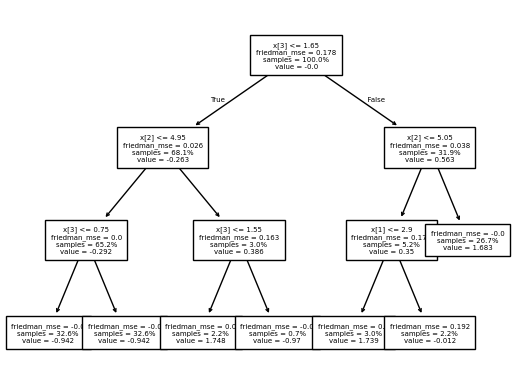

In [ ]:
sk_tree.plot_tree(tree, proportion=True, fontsize=5)
plt.show()

In [ ]:
set_option(rational_to_decimal=True)

In [ ]:
# Obter a fórmula AND de todos os caminhos da árvore
# combined_formula = get_all_paths_with_z3(tree)

# # Exibir a fórmula combinada
# print("Fórmula AND de todos os caminhos:")
# print(combined_formula)

# (I ^ B -> A)

##Fazer um AND entre as todos os caminhos da árvore e as restrições de máximo e mínimo das features.

In [ ]:
# Função para criar restrições de mínimo e máximo para cada feature
def get_feature_constraints(X):
    # Inicializa uma lista para armazenar as restrições
    constraints = []

    # Itera sobre cada feature (coluna) do dataset
    for i in range(X.shape[1]):
        feature_values = X[:, i]
        min_val, max_val = feature_values.min(), feature_values.max()

        # Cria a variável correspondente à feature
        x = Real(f'x{i}')
        min = RealVal(min_val)
        max = RealVal(max_val)
        # Adiciona a restrição de intervalo para essa feature
        constraint = And(min <= x, x <= max)
        constraints.append(constraint)

    # Combina todas as restrições em uma única expressão And
    return And(*constraints)

In [ ]:
# Essa função retorna uma fórmula que representa o B
def get_gb_formulas_and_constraints(model, X):
  '''
  Faz um AND entre a fórmulque representa todos os caminhos de todas as árvores
  de cada classe do modelo GradientBoostingClassifier e as restrições de mínimo
  e máximo de cada feature do dataset usado para treinar o modelo.
  '''
  gb_all_paths = generate_formulas_for_gb(model)
  feature_constraints = get_feature_constraints(X)
  return And(gb_all_paths, feature_constraints)

## Gerar a lista de fórmulas (I) para a amostra


In [ ]:
# Função para gerar fórmulas Z3 para uma lista de amostras
# Representa o I
def create_sample_formulas(sample):
    # Para cada valor na amostra, criamos uma equação do tipo `xN == value`
    formula = [Real(f'x{i}') == value for i, value in enumerate(sample)]
    return formula

## Experimentando as funções com o modelo gb_multiclass treinado com o dataset iris

In [ ]:
gb_tree_paths = generate_formulas_for_gb(gb_multiclass)
print(gb_tree_paths)

And(And(Implies(And(x3 <= 0.75, x1 <= 2.6000000238?),
                o_0_0 == 2.0454545454?),
        Implies(And(x3 <= 0.75,
                    x1 > 2.6000000238?,
                    x1 <= 2.9500000476?),
                o_0_0 == 2.0454545454?),
        Implies(And(x3 <= 0.75,
                    x1 > 2.6000000238?,
                    x1 > 2.9500000476?),
                o_0_0 == 2.0454545454?),
        Implies(And(x3 > 0.75, x0 <= 4.9500000476?),
                o_0_0 == -0.9890109890?),
        Implies(And(x3 > 0.75, x0 > 4.9500000476?),
                o_0_0 == -0.9890109890?)),
    And(Implies(And(x3 <= 0.75), o_0_1 == -1.0227272727?),
        Implies(And(x3 > 0.75,
                    x3 <= 1.75,
                    x2 <= 4.9500000476?),
                o_0_1 == 1.8496131528?),
        Implies(And(x3 > 0.75,
                    x3 <= 1.75,
                    x2 > 4.9500000476?),
                o_0_1 == 0.1523210831?),
        Implies(And(x3 > 0.75,
                    x3 > 

In [ ]:
feature_constraints = get_feature_constraints(iris.data)
print(feature_constraints)

And(And(4.3 <= x0, 7.9 >= x0),
    And(2 <= x1, 4.4 >= x1),
    And(1 <= x2, 6.9 >= x2),
    And(0.1 <= x3, 2.5 >= x3))


In [ ]:
gb_all_paths = generate_formulas_for_gb(gb_multiclass)
print(gb_all_paths)

And(And(Implies(And(x3 <= 0.75, x1 <= 2.6000000238?),
                o_0_0 == 2.0454545454?),
        Implies(And(x3 <= 0.75,
                    x1 > 2.6000000238?,
                    x1 <= 2.9500000476?),
                o_0_0 == 2.0454545454?),
        Implies(And(x3 <= 0.75,
                    x1 > 2.6000000238?,
                    x1 > 2.9500000476?),
                o_0_0 == 2.0454545454?),
        Implies(And(x3 > 0.75, x0 <= 4.9500000476?),
                o_0_0 == -0.9890109890?),
        Implies(And(x3 > 0.75, x0 > 4.9500000476?),
                o_0_0 == -0.9890109890?)),
    And(Implies(And(x3 <= 0.75), o_0_1 == -1.0227272727?),
        Implies(And(x3 > 0.75,
                    x3 <= 1.75,
                    x2 <= 4.9500000476?),
                o_0_1 == 1.8496131528?),
        Implies(And(x3 > 0.75,
                    x3 <= 1.75,
                    x2 > 4.9500000476?),
                o_0_1 == 0.1523210831?),
        Implies(And(x3 > 0.75,
                    x3 > 

In [ ]:
feature_constraints = get_feature_constraints(iris.data)
feature_constraints

And(And(4.3 <= x0, 7.9 >= x0),
    And(2 <= x1, 4.4 >= x1),
    And(1 <= x2, 6.9 >= x2),
    And(0.1 <= x3, 2.5 >= x3))

In [ ]:
# Fórmula que representa o B
gb_formulas = get_gb_formulas_and_constraints(gb_multiclass, iris.data)
print(gb_formulas)

And(And(And(Implies(And(x3 <= 3/4,
                        x1 <=
                        1300000011920929/500000000000000),
                    o_0_0 ==
                    10227272727272727/5000000000000000),
            Implies(And(x3 <= 3/4,
                        x1 >
                        1300000011920929/500000000000000,
                        x1 <=
                        737500011920929/250000000000000),
                    o_0_0 ==
                    10227272727272727/5000000000000000),
            Implies(And(x3 <= 3/4,
                        x1 >
                        1300000011920929/500000000000000,
                        x1 > 737500011920929/250000000000000),
                    o_0_0 ==
                    10227272727272727/5000000000000000),
            Implies(And(x3 > 3/4,
                        x0 <=
                        1237500011920929/250000000000000),
                    o_0_0 ==
                    -9890109890109889/10000000000000000),
            I

In [ ]:
# Fórmula que representa o I
# sample: [6.4, 2.9, 4.3, 1.3] (primeira amostra do X_iris_train)
sample_formulas = create_sample_formulas(X_iris_train[0])
print(sample_formulas)

[x0 == 32/5, x1 == 29/10, x2 == 43/10, x3 == 13/10]


In [ ]:
# Fórmula que representa o A
A = function_a(gb_multiclass, [X_iris_train[0]])
print(A)
# multz3 = function_a(gb_multiclass, [X_iris_test[0]])
# print(multz3)

pred class: 1
And((o_0_1 + o_1_1)*1/10 + 2884300165212499/5000000000000000 >
    (o_0_0 + o_1_0)*1/10 +
    -10992994631966263/500000000000000000,
    (o_0_1 + o_1_1)*1/10 + 2884300165212499/5000000000000000 >
    (o_0_2 + o_1_2)*1/10 +
    -1104094732716547/50000000000000000)


In [ ]:
def explain(I, B, A):
  X = I.copy()
  relevante = []

  for formula in I:
    X.remove(formula)
    s = Solver()
    s.add(Implies(And(And(X), B), A))
    print(s.check())

    # if s.check() == sat:
    #   continue
    # else:
    #   X.append(formula)

  return X

In [ ]:
explanation = explain(sample_formulas, gb_formulas, A)
print(explanation)

sat
sat
sat
sat
[]


In [ ]:
set_option(rational_to_decimal=True)

In [ ]:
print(sample_formulas)

[x0 == 6.4, x1 == 2.9, x2 == 4.3, x3 == 1.3]


In [ ]:
print(gb_formulas)

And(And(And(Implies(And(x3 <= 0.75, x1 <= 2.6000000238?),
                    o_0_0 == 2.0454545454?),
            Implies(And(x3 <= 0.75,
                        x1 > 2.6000000238?,
                        x1 <= 2.9500000476?),
                    o_0_0 == 2.0454545454?),
            Implies(And(x3 <= 0.75,
                        x1 > 2.6000000238?,
                        x1 > 2.9500000476?),
                    o_0_0 == 2.0454545454?),
            Implies(And(x3 > 0.75, x0 <= 4.9500000476?),
                    o_0_0 == -0.9890109890?),
            Implies(And(x3 > 0.75, x0 > 4.9500000476?),
                    o_0_0 == -0.9890109890?)),
        And(Implies(And(x3 <= 0.75),
                    o_0_1 == -1.0227272727?),
            Implies(And(x3 > 0.75,
                        x3 <= 1.75,
                        x2 <= 4.9500000476?),
                    o_0_1 == 1.8496131528?),
            Implies(And(x3 > 0.75,
                        x3 <= 1.75,
                        x2 > 4.950

In [ ]:
print(A)

And((o_0_1 + o_1_1)*0.1 + 0.5768600330? >
    (o_0_0 + o_1_0)*0.1 + -0.0219859892?,
    (o_0_1 + o_1_1)*0.1 + 0.5768600330? >
    (o_0_2 + o_1_2)*0.1 + -0.0220818946?)


In [ ]:
s = Solver()
s.add(Implies(And(And(sample_formulas), gb_formulas), A))
s.check()

sat

In [ ]:
x = ['cavalo', 'javali', 'zebra', 'morcego']
x.remove('cavalo')
x

['javali', 'zebra', 'morcego']

# test bin 1 estimator

In [ ]:
gb_binary = GradientBoostingClassifier(n_estimators = 10)

In [ ]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
simply_df = df # [['mean radius', 'mean texture', 'mean area']]
simply_data = simply_df.values
simply_data

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(simply_data, data.target, test_size=0.01, random_state=42)

In [ ]:
gb_simply_binary = gb_binary.fit(X_train, y_train)

In [ ]:
gb_simply_binary.predict(X_test)

array([1, 0, 0, 1, 1, 0])

In [ ]:
gb_all_paths = generate_formulas_for_gb(gb_simply_binary)
print(gb_all_paths)

And(And(Implies(And(x20 <= 3359000015258789/200000000000000,
                    x27 <=
                    13580000400543213/100000000000000000,
                    x10 <= 1047549992799759/1000000000000000),
                o_0_0 == 96144265094267/62500000000000),
        Implies(And(x20 <= 3359000015258789/200000000000000,
                    x27 <=
                    13580000400543213/100000000000000000,
                    x10 > 1047549992799759/1000000000000000),
                o_0_0 == -134688995215311/50000000000000),
        Implies(And(x20 <= 3359000015258789/200000000000000,
                    x27 >
                    13580000400543213/100000000000000000,
                    x21 <= 5134000015258789/200000000000000),
                o_0_0 == 860579775405589/1250000000000000),
        Implies(And(x20 <= 3359000015258789/200000000000000,
                    x27 >
                    13580000400543213/100000000000000000,
                    x21 > 5134000015258789/200000000000

In [ ]:
set_option(rational_to_decimal=True)

In [ ]:
feature_constraints = get_feature_constraints(simply_data)
print(feature_constraints)

And(And(6.981 <= x0, 28.11 >= x0),
    And(9.71 <= x1, 39.28 >= x1),
    And(43.79 <= x2, 188.5 >= x2),
    And(143.5 <= x3, 2501 >= x3),
    And(0.05263 <= x4, 0.1634 >= x4),
    And(0.01938 <= x5, 0.3454 >= x5),
    And(0 <= x6, 0.4268 >= x6),
    And(0 <= x7, 0.2012 >= x7),
    And(0.106 <= x8, 0.304 >= x8),
    And(0.04996 <= x9, 0.09744 >= x9),
    And(0.1115 <= x10, 2.873 >= x10),
    And(0.3602 <= x11, 4.885 >= x11),
    And(0.757 <= x12, 21.98 >= x12),
    And(6.802 <= x13, 542.2 >= x13),
    And(0.001713 <= x14, 0.03113 >= x14),
    And(0.002252 <= x15, 0.1354 >= x15),
    And(0 <= x16, 0.396 >= x16),
    And(0 <= x17, 0.05279 >= x17),
    And(0.007882 <= x18, 0.07895 >= x18),
    And(0.0008948 <= x19, 0.02984 >= x19),
    And(7.93 <= x20, 36.04 >= x20),
    And(12.02 <= x21, 49.54 >= x21),
    And(50.41 <= x22, 251.2 >= x22),
    And(185.2 <= x23, 4254 >= x23),
    And(0.07117 <= x24, 0.2226 >= x24),
    And(0.02729 <= x25, 1.058 >= x25),
    And(0 <= x26, 1.252 >= x26),
    

In [ ]:
B = And(gb_all_paths, feature_constraints)
print(B)

And(And(And(Implies(And(x20 <= 16.7950000762?,
                        x27 <= 0.1358000040?,
                        x10 <= 1.0475499927?),
                    o_0_0 == 1.5383082415?),
            Implies(And(x20 <= 16.7950000762?,
                        x27 <= 0.1358000040?,
                        x10 > 1.0475499927?),
                    o_0_0 == -2.6937799043?),
            Implies(And(x20 <= 16.7950000762?,
                        x27 > 0.1358000040?,
                        x21 <= 25.6700000762?),
                    o_0_0 == 0.6884638203?),
            Implies(And(x20 <= 16.7950000762?,
                        x27 > 0.1358000040?,
                        x21 > 25.6700000762?),
                    o_0_0 == -2.2177604171?),
            Implies(And(x20 > 16.7950000762?,
                        x21 <= 19.9099998474?,
                        x15 <= 0.0207050004?),
                    o_0_0 == 1.5903954802?),
            Implies(And(x20 > 16.7950000762?,
                        x21 <

In [ ]:
A = function_a(gb_simply_binary, [X_test[2]])
print(A)

pred class: 0
And((o_0_0 +
     o_1_0 +
     o_2_0 +
     o_3_0 +
     o_4_0 +
     o_5_0 +
     o_6_0 +
     o_7_0 +
     o_8_0 +
     o_9_0)*
    0.1 +
    0.5269626611? <
    0)


In [ ]:
def bool_prove(f):
    s = Solver()
    s.add(Not(f))
    if s.check() == unsat:
        return True
    else:
        return False

In [ ]:
def explain(I, B, A):
  X = I.copy()
  relevante = []

  for formula in I:
    X.remove(formula)

    if bool_prove(Implies(And(And(X), B), A)):
      continue
      # print('proved')
    else:
      # print('not proved')
      X.append(formula)

  return X

In [ ]:
I = create_sample_formulas(X_test[2])
print((X_test[0]))
print(I)

[1.247e+01 1.860e+01 8.109e+01 4.819e+02 9.965e-02 1.058e-01 8.005e-02
 3.821e-02 1.925e-01 6.373e-02 3.961e-01 1.044e+00 2.497e+00 3.029e+01
 6.953e-03 1.911e-02 2.701e-02 1.037e-02 1.782e-02 3.586e-03 1.497e+01
 2.464e+01 9.605e+01 6.779e+02 1.426e-01 2.378e-01 2.671e-01 1.015e-01
 3.014e-01 8.750e-02]
[x0 == 15.46, x1 == 19.48, x2 == 101.7, x3 == 748.9, x4 == 0.1092, x5 == 0.1223, x6 == 0.1466, x7 == 0.08087, x8 == 0.1931, x9 == 0.05796, x10 == 0.4743, x11 == 0.7859, x12 == 3.094, x13 == 48.31, x14 == 0.00624, x15 == 0.01484, x16 == 0.02813, x17 == 0.01093, x18 == 0.01397, x19 == 0.002461, x20 == 19.26, x21 == 26, x22 == 124.9, x23 == 1156, x24 == 0.1546, x25 == 0.2394, x26 == 0.3791, x27 == 0.1514, x28 == 0.2837, x29 == 0.08019]


In [ ]:
test = explain(I, B, A)
print(test)

[x7 == 0.08087, x21 == 26, x22 == 124.9, x23 == 1156, x24 == 0.1546, x26 == 0.3791, x27 == 0.1514]


In [ ]:
print(I)

[x0 == 15.46, x1 == 19.48, x2 == 101.7, x3 == 748.9, x4 == 0.1092, x5 == 0.1223, x6 == 0.1466, x7 == 0.08087, x8 == 0.1931, x9 == 0.05796, x10 == 0.4743, x11 == 0.7859, x12 == 3.094, x13 == 48.31, x14 == 0.00624, x15 == 0.01484, x16 == 0.02813, x17 == 0.01093, x18 == 0.01397, x19 == 0.002461, x20 == 19.26, x21 == 26, x22 == 124.9, x23 == 1156, x24 == 0.1546, x25 == 0.2394, x26 == 0.3791, x27 == 0.1514, x28 == 0.2837, x29 == 0.08019]


In [ ]:
print(B)

And(And(And(Implies(And(x20 <= 16.7950000762?,
                        x27 <= 0.1358000040?,
                        x10 <= 1.0475499927?),
                    o_0_0 == 1.5383082415?),
            Implies(And(x20 <= 16.7950000762?,
                        x27 <= 0.1358000040?,
                        x10 > 1.0475499927?),
                    o_0_0 == -2.6937799043?),
            Implies(And(x20 <= 16.7950000762?,
                        x27 > 0.1358000040?,
                        x21 <= 25.6700000762?),
                    o_0_0 == 0.6884638203?),
            Implies(And(x20 <= 16.7950000762?,
                        x27 > 0.1358000040?,
                        x21 > 25.6700000762?),
                    o_0_0 == -2.2177604171?),
            Implies(And(x20 > 16.7950000762?,
                        x21 <= 19.9099998474?,
                        x15 <= 0.0207050004?),
                    o_0_0 == 1.5903954802?),
            Implies(And(x20 > 16.7950000762?,
                        x21 <

In [ ]:
print(A.arg(0))

(o_0_0 +
 o_1_0 +
 o_2_0 +
 o_3_0 +
 o_4_0 +
 o_5_0 +
 o_6_0 +
 o_7_0 +
 o_8_0 +
 o_9_0)*
0.1 +
0.5269626611? <
0


In [ ]:
res = prove(And(And(I), B))

counterexample
[x3 = 0,
 x23 = 710.2004144569?,
 x13 = 542.2004022499?,
 o_3_0 = -1.8913480143?,
 o_7_0 = -2.0022989913?,
 o_8_0 = -1.4575622542?,
 x20 = 36.0404022499?,
 x22 = 115.9503991981?,
 x7 = 0.2016022499?,
 x1 = 39.2804022499?,
 x16 = 0.3964022499?,
 x25 = 1.0584022499?,
 x10 = 2.8734022499?,
 x21 = 49.5404022499?,
 x26 = 1.2524022499?,
 o_2_0 = 1.5210507088?,
 x0 = 0,
 x6 = -0.0004022499?,
 x2 = 188.5004022499?,
 o_4_0 = -1.7851433481?,
 o_9_0 = -1.8617879607?,
 o_0_0 = -2.6937799043?,
 x12 = 0,
 x19 = 0.0302422499?,
 x24 = 0.2230022499?,
 x17 = 0.0105277500?,
 x5 = 0,
 x9 = 0,
 x4 = 0,
 x14 = 0.0315322499?,
 x28 = 0.1569522475?,
 x8 = 0,
 o_6_0 = -1.6189351781?,
 x15 = 0.1358022499?,
 x27 = 0.2914022499?,
 x29 = 0.0555272498?,
 x18 = 0,
 o_1_0 = -2.2938013534?,
 x11 = 4.8854022499?,
 o_5_0 = -1.7056552785?]


In [ ]:
print(res)

None


In [ ]:
res = prove(Implies(And(And(I), B), A))
print(res)
if not res:
  print('y')

proved
None
y


In [ ]:
solve(And(And(I), Implies(B, A)))

[x3 = 748.9,
 x13 = 48.31,
 x23 = 1156,
 x22 = 124.9,
 x20 = 19.26,
 x1 = 19.48,
 x26 = 0.3791,
 x10 = 0.4743,
 x16 = 0.02813,
 x25 = 0.2394,
 x21 = 26,
 x6 = 0.1466,
 x2 = 101.7,
 o_4_0 = -2.6901621039?,
 x12 = 3.094,
 x19 = 0.002461,
 x24 = 0.1546,
 x9 = 0.05796,
 x4 = 0.1092,
 x5 = 0.1223,
 x17 = 0.01093,
 x8 = 0.1931,
 x14 = 0.00624,
 x28 = 0.2837,
 x15 = 0.01484,
 x27 = 0.1514,
 x29 = 0.08019,
 x18 = 0.01397,
 x11 = 0.7859,
 x0 = 15.46,
 x7 = 0.08087]


In [ ]:
s = Solver()
s.check((And(And(And(I), B), A)))

sat

In [ ]:
print(solve((And(And(And(I), B), A))))

[x0 = 773/50,
 x13 = 4831/100,
 x23 = 1156,
 o_3_0 = -18369076478563753/10000000000000000,
 o_7_0 = -354610153350229/250000000000000,
 o_8_0 = -6825739851595597/5000000000000000,
 x20 = 963/50,
 x7 = 8087/100000,
 x3 = 7489/10,
 x1 = 487/25,
 x10 = 4743/10000,
 x16 = 2813/100000,
 x25 = 1197/5000,
 x21 = 26,
 x26 = 3791/10000,
 o_2_0 = -63813418140983/31250000000000,
 x22 = 1249/10,
 x6 = 733/5000,
 x2 = 1017/10,
 o_4_0 = -8450810519865507/5000000000000000,
 o_9_0 = -273151328533777/200000000000000,
 o_0_0 = -26684297541018873/10000000000000000,
 x19 = 2461/1000000,
 x12 = 1547/500,
 x24 = 773/5000,
 x9 = 1449/25000,
 x4 = 273/2500,
 x5 = 1223/10000,
 x17 = 1093/100000,
 x8 = 1931/10000,
 x14 = 39/6250,
 x28 = 2837/10000,
 o_6_0 = -7476569154935153/5000000000000000,
 x15 = 371/25000,
 x27 = 757/5000,
 x29 = 8019/100000,
 x18 = 1397/100000,
 o_1_0 = -4546028100063591/2000000000000000,
 x11 = 7859/10000,
 o_5_0 = -8039287314078639/5000000000000000]
None
